In [5]:
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'
%reload_ext autoreload
%autoreload 2
from scanpy_helpers import *
print ('scanpy version: {}'.format(sc.__version__))
warnings.filterwarnings('ignore')
%matplotlib inline

# path = 'dir'
path = 'indir'

pre_adata = pd.read_csv(f's3://darmanis-group/singlecell_meldiff/mel_diff_ryan/{path}_all_COI_rawdata.csv', 
                      index_col=[0])
pre_adata.index.name = 'gene_name'

meta_data = pd.read_csv(f's3://darmanis-group/singlecell_meldiff/mel_diff_ryan/{path}_all_COI_metadata.csv', 
                      index_col=[0])
meta_data.index.name = 'cell_name'
             

scanpy version: 1.3.3


In [6]:
raw_adata = create_adata(pre_adata)
raw_adata.var['ribo'] = raw_adata.var_names.str.startswith(('RPL','RPS'))
sc.pp.calculate_qc_metrics(raw_adata, feature_controls=['ribo'], inplace=True)
anno_dict = {'nGene':'nGene',
             'nUMI':'nUMI',
             'sample':'sample'
            }
append_anno(raw_adata, meta_data, anno_dict)
technical_filters(raw_adata, min_genes=0,min_counts=0,min_cells=0)
raw_adata = remove_ercc(raw_adata)
raw_adata.raw = sc.pp.log1p(raw_adata, copy=True) # freeze raw state

Ingest raw data...
	Cells: 19594, Genes: 26577
Append annotations...
	Cells: 19594, Genes: 26577
Remove low-quality cells/genes...
	Initial:
	Cells: 19594, Genes: 26577
	Result:
	Cells: 19594, Genes: 26577
Remove ERCC genes...
Filtered genes: 103
	Cells: 19594, Genes: 26474


Process expression data...
	Initial:
	Cells: 19594, Genes: 26474
min mean expression (min_mean): 0.0125
max mean expression (max_mean)): 10
min dispresion (min_disp): 0.1
Filtered cells: 0
Filtered genes: 21200
	Result:
	Cells: 19594, Genes: 5274
Principle component analysis...


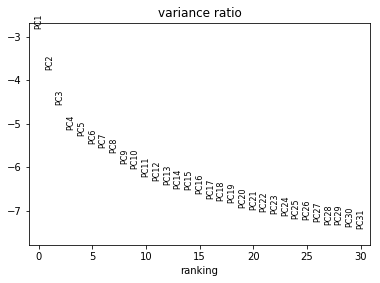

principle_components(num_pcs): 30
cells/neighborhood(hoods): 30
Uniform manifold approximation and projection...
	Scan Louvain detection resolutions
	resolution_interval(step_size): 0.05


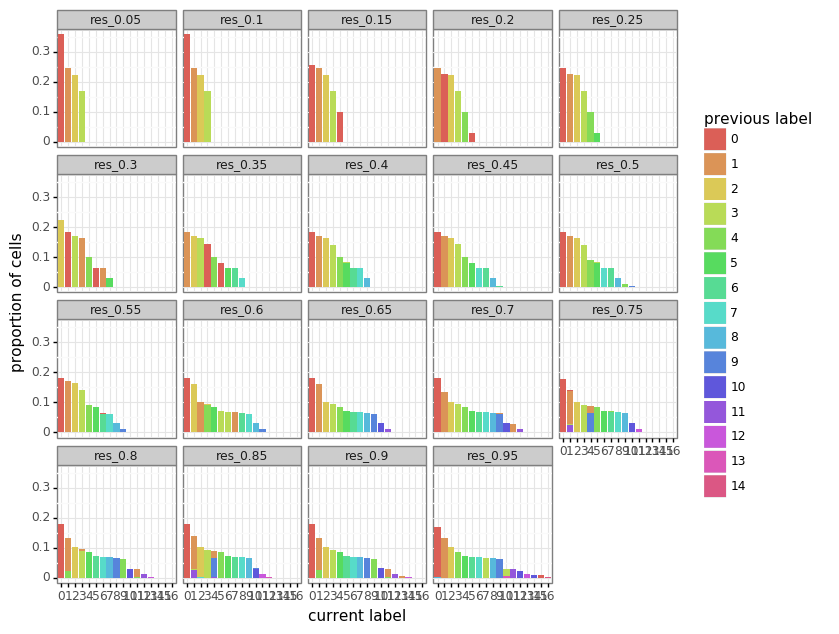

<ggplot: (-9223363290332319842)>


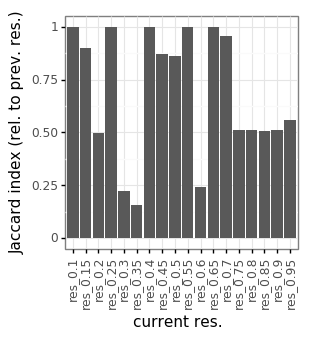

<ggplot: (-9223363290673975061)>
resolution(res): 0.25


... storing 'sample' as categorical


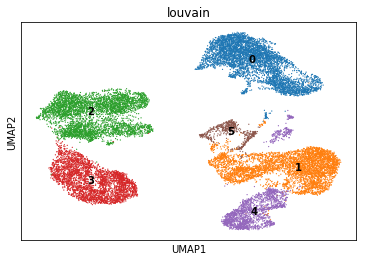

In [7]:
full_adata = process_adata(raw_adata)
pca_adata(full_adata, num_pcs=30)
umap_adata(full_adata, res=0.25)

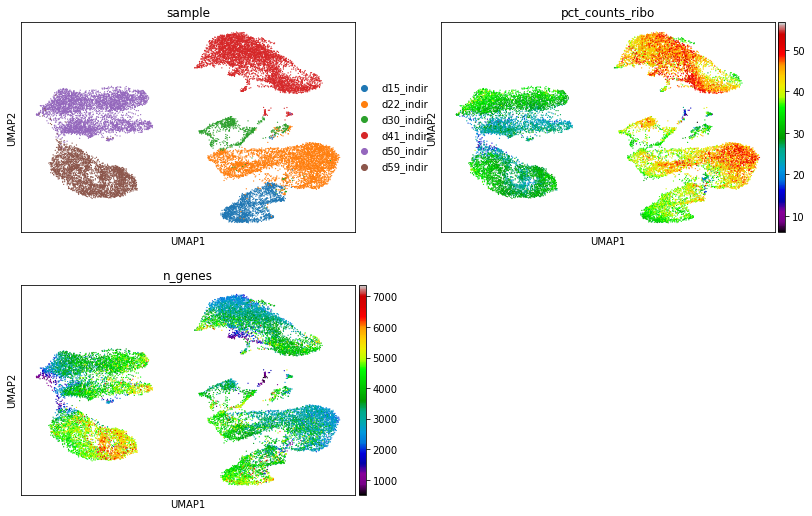

In [8]:
sc.pl.umap(full_adata, color = ['sample','pct_counts_ribo','n_genes'], cmap = 'nipy_spectral', ncols = 2)


In [ ]:
# classify in raw adata
input_adata = full_adata

MEL_int = [0,1,3,4]
KRT_int = [x for x in range(len(input_adata.obs['louvain'].cat.categories)) if x not in MEL_int]
type_dict = {'KRT':[str(x) for x in KRT_int],
             'MEL':[str(x) for x in MEL_int]}
    
classify_type(raw_adata, input_adata, 'louvain', type_dict, 'class_1')

In [ ]:
# MEL only

feature_dict = {'class_1':['MEL']}
adata_subset1 = subset_adata_v3(raw_adata,feature_dict)
adata_subset1 = process_adata(adata_subset1)
pca_adata(adata_subset1, num_pcs=30)
umap_adata(adata_subset1, res=0.15)

In [ ]:
# initial PC coordinates
sc.pl.pca(adata_subset1, components=['1,2', '2,3','3,4'], color=['louvain'])

# cull cells using Tukey outlier threshold
df = pd.DataFrame(adata_subset1.obsm['X_pca'])
df.columns = ['PC_{}'.format(x) for x in range(50)]

omit_names = []
for pc in df.columns:
#     print(len(set(omit_names)))
    Q1 = df[pc].quantile(0.25)
    Q3 = df[pc].quantile(0.75)
    IQR = Q3 - Q1
    threshold=5

    bool_idx = [True if ((Q1 - threshold * IQR) <= x <= (Q3 + threshold * IQR)) else False for x in df[pc]]
    filtered = df[bool_idx]
#     print('Filtered cells: ', len(df)-len(filtered))
    
    omit_names = omit_names + adata_subset1.obs[[not x for x in bool_idx]].index.tolist()

print('Filtered cells: ', len(set(omit_names)))

# check where the outliers lie in original projection
input_adata = adata_subset1
input_adata.obs['outliers'] = ['outlier' if x in set(omit_names) else 'ingroup' for x in input_adata.obs.index]

# outliers among adt-mels
sc.pl.pca(adata_subset1, components=['1,2', '2,3','3,4'], color=['outliers'])
sc.pl.umap(input_adata, color=['outliers'], cmap='magma')

# outliers on all-cells projection
input_adata = adata_subset1

type_dict = {'ingroup':['ingroup'],
             'outlier':['outlier']}
    
classify_type(full_adata, input_adata, 'outliers', type_dict, 'outliers')

sc.pl.umap(full_adata, color=['outliers'])

In [ ]:
# classify in raw adata
input_adata = adata_subset1

type_dict = {'in':['ingroup'],
             'out':['outlier']}
    
classify_type(raw_adata, input_adata, 'outliers', type_dict, 'class_2')

feature_dict = {'class_2':['in']}
adata_subset2 = subset_adata_v3(raw_adata,feature_dict)
adata_subset2 = process_adata(adata_subset2)
pca_adata(adata_subset2, num_pcs=10)
umap_adata(adata_subset2, res=0.35)

In [ ]:
# calculate txn noise
input_adata = adata_subset2
groupby = ['patient','anatomical_location']
features_df = (input_adata.obs.loc[:,groupby]
               .drop_duplicates()
               .reset_index()
               .drop('index', axis = 1))

noise_df = pd.DataFrame()
for row in range(len(features_df)):
    feature_slice = pd.DataFrame(features_df.iloc[row,:]).T
    filtered_adata = input_adata
    noise_group = []
    for col in feature_slice.columns:
        feature_match = feature_slice[col].values[0]
        filtered_adata = filtered_adata[filtered_adata.obs[col] == feature_match]
        noise_group.append(feature_match)

    cell_list = filtered_adata.obs.index.tolist()
    noise_slice = txn_noise_spearman(cell_list, pre_adata)
    noise_slice['noise_group'] = '_'.join(noise_group)
    noise_df = noise_df.append(noise_slice)

# update adata
ordered_noise = pd.merge(pd.DataFrame({'cell':adata_subset2.obs.index}), noise_df, 'left', 'cell')
adata_subset2.obs['agg_noise'] = ordered_noise.noise.values
adata_subset2.obs['noise_group'] = ordered_noise.noise_group.values
    

In [ ]:
# krt only re-cluster
feature_dict = {'class_1':['KRT']}
adata_subset1_KRT = subset_adata_v3(raw_adata,feature_dict)
adata_subset1_KRT = process_adata(adata_subset1_KRT)
pca_adata(adata_subset1_KRT, num_pcs=10)
umap_adata(adata_subset1_KRT, res=0.2)

In [ ]:
# pickle adatas
for objname in ['full_adata','adata_subset1','adata_subset2','pre_adata','adata_subset1_KRT']:
    pickle.dump(eval(objname), open( f"{wkdir}/{objname}.p", "wb" ) )
    syscmd = f'aws s3 cp {wkdir}/{objname}.p s3://{s3dir}/'
    subprocess.run(syscmd.split(' '))